In [11]:
%matplotlib notebook
import mygrad as mg

In [2]:
from cogworks_data.language import get_data_path

from pathlib import Path
import json

# load COCO metadata
filename = get_data_path("captions_train2014.json")
with Path(filename).open() as f:
    coco_data = json.load(f)

In [3]:
from gensim.models import KeyedVectors
filename = "glove.6B.200d.txt.w2v"

# this takes a while to load -- keep this in mind when designing your capstone project
glove = KeyedVectors.load_word2vec_format(get_data_path(filename), binary=False, limit=500000)

In [14]:
import pickle
with Path(get_data_path('resnet18_features.pkl')).open('rb') as f:
    resnet18_features = pickle.load(f)

In [5]:
# imports which aren't yet here because I'm lazy

In [6]:
from mynn.layers.dense import dense
from mygrad.nnet.initializers import glorot_normal
import numpy as np

class Model():
    """
    Model that creates semantic space embeddings using the original image vectors
    """
    def __init__(self, input_dim, output_dim, stored_weights=None):
        """ 
        Initializes the layer
        
        Parameters
        ----------
        dim_input: int 
            The original image descriptor vector dimension
        
        dim_output: int
            The final image embedding dimension
        """
        self.dense_layer = dense(input_dim, output_dim, weight_initializer=glorot_normal, bias=False)
        if stored_weights is not None:
            self.dense_layer.weight = mg.astensor(stored_weights)
    def __call__(self, x):
        """
        Does one forward pass of the network
        
        Parameters
        ----------
        x: Union[numpy.ndarray, mygrad.Tensor], shape=(training data length, input_dim)
            The training data of image descriptor vectors
        
        Returns
        -------
        mygrad.Tensor, shape=(training data length, output_dim)
            The normalized image embeddings predicted by the model
        """
        embeddings = self.dense_layer(x)
        return embeddings / np.linalg.norm(embeddings)
        
    @property
    def parameters(self):
        """
        Gets the model's parameters
        
        Returns
        -------
        Tuple[Tensor, ...]
            The weights of the model
        """
        return self.dense_layer.parameters

In [7]:
def load_weights():
    """ 
        Loads the weights from the numpy array file
        
        Returns
        -------
        The array of weights
        """
    return np.load('WeightsArray.npy')

def save_weights(arr: np.array):
    """ 
        Stores the weights to the numpy array file
        
        Parameters
        ----------
        arr: np.array
            The array of weights
        """
    np.save('WeightsArray.npy', arr)

<IPython.core.display.Javascript object>


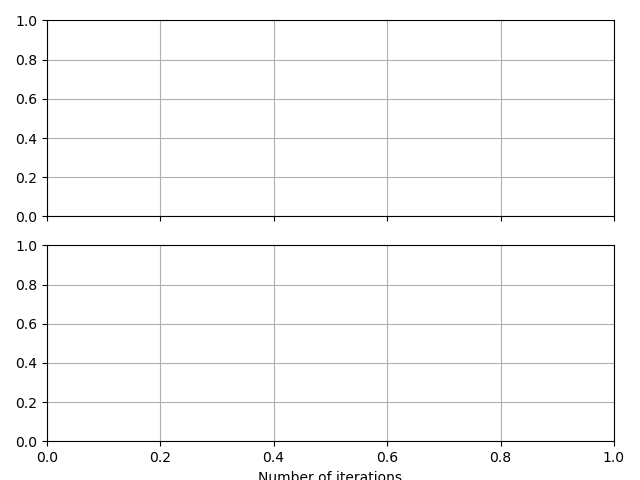

In [8]:
import matplotlib.pyplot as plt
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

In [9]:
from mynn.optimizers.sgd import SGD

model = Model(512, 200)
optimizer = SGD(model.parameters, learning_rate = 1e-3, momentum=0.9)

In [12]:
# only run if we actually stored weights to use, need this cell for testing
model2 = Model(512, 200, load_weights())

In [15]:
from OmniCog import CocoDataManager, train_split, extract_triples
from OmniCog import margin_loss, batch_accuracy

epochs = 10
batch_size = 32

manager = CocoDataManager(coco_data, resnet18_features)

training, testing = train_split(manager.imageIDs)

for iteration in range(0, epochs):
    training_data = extract_triples(manager, training)
    # creates a shuffled array of training indices
    indices = np.arange(len(training_data))
    np.random.shuffle(indices)
    
    # trains the model by improving the loss and accuracy metrics for the training data in batches
    for batch_count in range(0, len(training_data)//batch_size):
        batch_indices = indices[batch_count * batch_size : (batch_count+1) * batch_size]
        batch = training_data[batch_indices]
        
        true_embedding = model([resnet18_features[true_vec] for (true_vec, caption, confuse_vec) in batch]) 
        confuser_embedding = model([resnet18_features[confuse_vec] for (true_vec, caption, confuse_vec) in batch])
        
        caption_embedding = [manager.captionID_to_captionEmbedding[caption] for (true_vec, caption, confuse_vec) in batch]
        
        print(true_embedding.shape, caption_embedding.shape, confuser_embedding.shape)
        loss = margin_loss(true_embedding, caption_embedding, confuser_embedding)
        accuracy = batch_accuracy(loss)
        
        loss.backward()
        optimizer.step()
        
        plotter.set_train_batch({"loss":loss.item(), "accuracy":accuracy}, batch_size=batch_size, plot=False)

    # creates a shuffled array of training indices  
    testing_data = extract_triples("captions_train2014.json", testing, validation=True)
    test_indices = np.arange(len(testing_data))
    np.random.shuffle(test_indices)
        
    # calculates the loss and accuracy for the validation data in batches
    for batch_count in range(0, len(testing_data)//batch_size):
        testing_data = extract_triples(manager, testing, validation=True)
        test_batch_indices = test_indices[batch_count * batch_size : (batch_count+1) * batch_size]
        test_batch = testing_data[test_batch_indices]
        
        true_embedding = model([resnet18_features[true_vec] for (true_vec, caption, confuse_vec) in test_batch]) 
        confuser_embedding = model([resnet18_features[confuse_vec] for (true_vec, caption, confuse_vec) in test_batch])
        
        caption_embedding = [manager.captionID_to_captionEmbedding[caption] for (true_vec, caption, confuse_vec) in test_batch]
        
        test_loss = loss(true_embedding, caption_embedding, confuser_embedding)
        test_accuracy = accuracy(test_loss)
        
        plotter.set_test_batch({"loss":test_loss.item(), "accuracy":test_accuracy}, batch_size=batch_size, plot=False)
    
    # plots the loss and accuracy in each epoch
    plotter.set_train_epoch()
    plotter.set_test_epoch()

# stores the final weights in a file
save_weights(model.parameters)

NameError: name 'resnet18_features' is not defined